In [292]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import quantstats as qs
import matplotlib.pyplot as plt

In [293]:
path = './fai_close_data.json'
with open(path, 'r') as f:
    data = json.load(f)

In [294]:
# Create a new dictionary with the desired format
parsed_data = {}
for key, value in data.items():
    parsed_data[key] = {}
    for inner_key, inner_value in value.items():
        parsed_data[key][inner_value['ISU_SRT_CD']] = int(inner_value['TDD_CLSPRC'].replace(',', ''))

In [295]:
# Convert the new dictionary to a pandas DataFrame
price = pd.DataFrame.from_dict(parsed_data, orient='index')
price.index = pd.to_datetime(price.index, format='%Y%m%d')
price

,068400,006840,027410,138930,001460,001465,001040,079160,000120,011150,...,350520,348950,357120,363280,36328K,352820,339770,244920,009900,365550
2015-01-02,17000,85100,74400,14400,262500,169000,157500,58200,187500,2545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,17600,89500,72500,14200,260500,167500,159500,61000,182500,2545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,17650,88600,72200,14050,257000,168000,158500,59100,181500,2595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,17750,86600,74500,13500,252000,168500,158500,59800,183500,2595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,17550,86000,74800,13900,246000,167500,164000,58800,184500,2600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,8890,23600,4850,5810,278500,140000,86300,23100,163000,5040,...,5050.0,5330.0,4795.0,24550.0,25750.0,153000.0,20150.0,5600.0,45700.0,5190.0
2020-12-24,8900,25200,5000,5940,284000,139500,88400,23800,163500,5030,...,5060.0,5270.0,4800.0,24900.0,25750.0,158000.0,19750.0,5820.0,41100.0,5210.0
2020-12-28,8980,24900,5080,6050,283500,136500,89300,23700,164000,4855,...,5040.0,5210.0,4810.0,24750.0,25750.0,156500.0,19050.0,5780.0,40650.0,5120.0
2020-12-29,9030,25100,4955,5670,285000,138000,91100,24250,164000,5030,...,4925.0,5140.0,4810.0,26300.0,26100.0,158500.0,19350.0,5570.0,41000.0,5080.0


#### Parameters
#### 1. Window_size : 20(1월) 60(3월), 120(6월), 240(12월)
#### 2. Holdings : 20(1월) 60(3월), 120(6월), 240(12월)

In [296]:
periods = 240 # time_steps
holdings = 20 # holding 기간(리밸런싱 주기)
ts_mom = price.pct_change(periods).dropna(how='all').T
cs_mom = price.pct_change(periods).dropna(how = 'all').T

## Time Series Momentum

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-12-18  2015-12-18
End Period          2020-12-08  2020-12-08
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   19.18%      6.76%
CAGR﹪              3.59%       1.32%

Sharpe              -0.17       0.36
Prob. Sharpe Ratio  34.22%      81.78%
Sortino             -0.2        0.95
Sortino/√2          -0.14       0.67
Omega               0.93        0.93

Max Drawdown        -110.37%    -66.32%
Longest DD Days     1437        1644

Gain/Pain Ratio     -0.07       0.12
Gain/Pain (1M)      -0.22       0.5

Payoff Ratio        1.19        1.31
Profit Factor       0.93        1.12
Common Sense Ratio  0.93        1.08
CPC Index           0.54        0.62
Tail Ratio          1.01        0.97
Outlier Win Ratio   4.81        9.99
Outlier Loss Ratio  2.6         8.48

MTD                 -3.05%      -2.1%
3M                  11.31%      1.89%

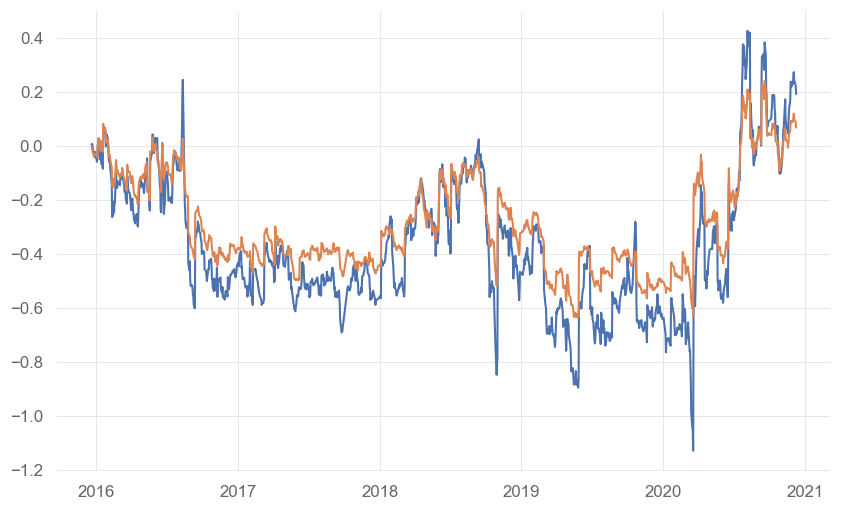

In [297]:
long_time, long_short_time = pd.DataFrame(), pd.DataFrame()
for i in range(divmod(len(ts_mom.columns),holdings)[0]):
    ################## holdings기간 마다 TSM>0, TSM<0 인 종목 구하기 ##################
    ts_returns = ts_mom[ts_mom.columns[holdings * i]].dropna()
    long_time_temp = pd.DataFrame((ts_mom.loc[ts_returns.index].loc[ts_returns.values > 0].iloc[:,holdings* i :holdings* (i+1)]).mean())
    short_time_temp = pd.DataFrame((ts_mom.loc[ts_returns.index].loc[ts_returns.values < 0].iloc[:,holdings* i :holdings* (i+1)]).mean())
    long_short_time_temp = long_time_temp - short_time_temp
    ################## Long & Long/Short Portfolio  구성하기 ##################
    long_time = pd.concat([long_time, long_time_temp])# Long Portfolio
    long_short_time = pd.concat([long_short_time, long_short_time_temp]) # Long/Short Portfolio

################## Daily Return 구하기 ##################
long_time.columns = ['rts'] 
long_short_time.columns = ['rts']
long_time, long_short_time = long_time.pct_change(), long_short_time.pct_change()

################## Backtest 진행 ##################
print(qs.reports.metrics(long_time,long_short_time, periods_per_year= periods))
plt.plot(((long_time + 1).cumprod() - 1))
plt.plot(((long_short_time + 1).cumprod() - 1))
plt.show()

## Cross-Sectional Momentum

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-12-18  2015-12-18
End Period          2020-12-08  2020-12-08
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   319.48%     248.36%
CAGR﹪              33.38%      28.49%

Sharpe              -0.09       0.07
Prob. Sharpe Ratio  42.18%      56.16%
Sortino             -0.26       0.17
Sortino/√2          -0.19       0.12
Omega               0.94        0.94

Max Drawdown        -285.8%     -294.64%
Longest DD Days     1297        1562

Gain/Pain Ratio     -0.06       0.1
Gain/Pain (1M)      -0.1        0.15

Payoff Ratio        2.01        0.84
Profit Factor       0.94        1.1
Common Sense Ratio  0.58        0.69
CPC Index           0.51        0.25
Tail Ratio          0.62        0.62
Outlier Win Ratio   4.13        2.23
Outlier Loss Ratio  11.22       7.21

MTD                 202.64%     260.02%
3M                  -32.01%     

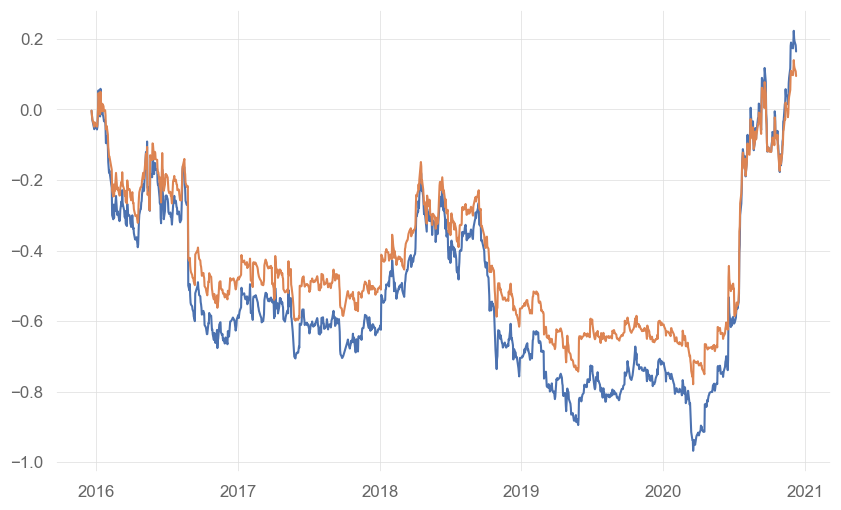

In [298]:
long_cross, long_short_cross = pd.DataFrame(), pd.DataFrame()
for i in range(divmod(len(cs_mom.columns),holdings)[0]):
    ################## holdings기간 마다 CSM 상하위 10% 종목 구하기 ##################
    cs_returns = cs_mom[cs_mom.columns[holdings * i]].dropna()
    percent10 = int(len(cs_returns)*0.1)
    long_cross_temp = pd.DataFrame(cs_mom.loc[cs_returns.index].sort_values(by = cs_mom.columns[holdings * i], ascending = False).iloc[:,holdings* i :holdings* (i+1)].head(percent10).mean())
    short_cross_temp = pd.DataFrame(cs_mom.loc[cs_returns.index].sort_values(by = cs_mom.columns[holdings * i], ascending = False).iloc[:,holdings* i :holdings* (i+1)].tail(percent10).mean())
    long_short_cross_temp = long_cross_temp - short_cross_temp
    ################## Long & Long/Short Portfolio  구성하기 ##################
    long_cross = pd.concat([long_cross, long_cross_temp]) # Long Portfolio
    long_short_cross = pd.concat([long_short_cross, long_short_cross_temp]) # Long/Short Portfolio

################## Daily Return 구하기 ##################    
long_cross.columns = ['rts'] 
long_short_cross.columns = ['rts']
long_cross, long_short_cross = long_cross.pct_change(), long_short_cross.pct_change()

################## Backtest 진행 ##################
print(qs.reports.metrics(long_cross.pct_change(),long_short_cross.pct_change()))
plt.plot(((long_cross + 1).cumprod() - 1))
plt.plot(((long_short_cross + 1).cumprod() - 1))
plt.show()

## Dual Momentum

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2015-12-18  2015-12-18
End Period          2020-12-08  2020-12-08
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   51.36%      36.65%
CAGR﹪              8.68%       6.47%

Sharpe              0.59        0.48
Prob. Sharpe Ratio  94.47%      87.84%
Sortino             1.5         1.08
Sortino/√2          1.06        0.76
Omega               1.19        1.19

Max Drawdown        -90.65%     -80.86%
Longest DD Days     1531        1492

Gain/Pain Ratio     0.19        0.13
Gain/Pain (1M)      0.94        0.64

Payoff Ratio        1.51        1.43
Profit Factor       1.19        1.13
Common Sense Ratio  1.18        1.26
CPC Index           0.81        0.71
Tail Ratio          1.0         1.11
Outlier Win Ratio   5.15        7.11
Outlier Loss Ratio  4.06        5.6

MTD                 2.02%       2.14%
3M                  16.78%      15.1

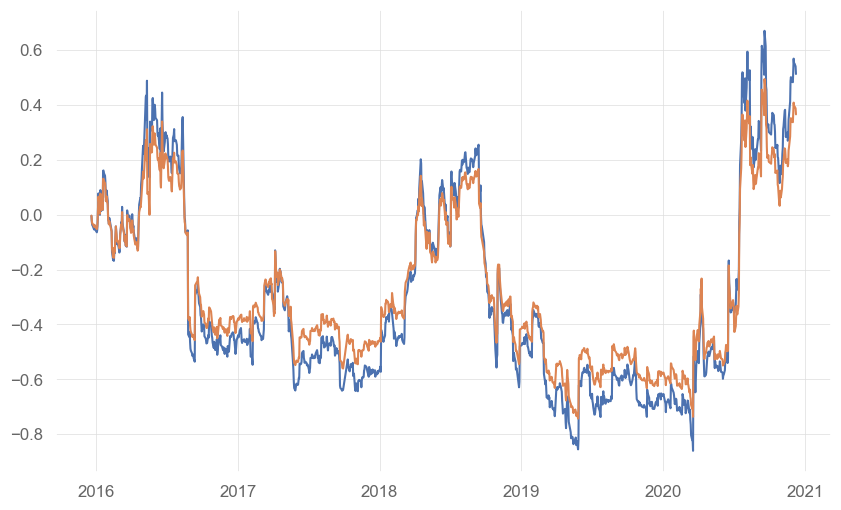

In [299]:
long_dual, long_short_dual = pd.DataFrame(), pd.DataFrame()
for i in range(divmod(len(ts_mom.columns),holdings)[0]):
    ################## holdings기간 마다 TSM>0, TSM<0 인 종목 구하기 ##################
    ts_returns = ts_mom[ts_mom.columns[holdings*i]].dropna()
    _long_time = ts_mom.loc[ts_returns.index].loc[ts_returns.values > 0]
    _short_time = ts_mom.loc[ts_returns.index].loc[ts_returns.values < 0]
    ################## holdings기간 마다 TSM>0(TSM<0)인 종목 중 상(하)위 10% 종목 구하기 ##################
    long_dual_temp = pd.DataFrame(cs_mom.loc[ts_returns.index].sort_values(by = cs_mom.columns[holdings * i], ascending = False).head(int(len(_long_time)*0.1)).iloc[:,holdings* i :holdings* (i+1)].mean())
    short_dual_temp = pd.DataFrame(cs_mom.loc[ts_returns.index].sort_values(by = cs_mom.columns[holdings * i], ascending = False).tail(int(len(_short_time)*0.1)).iloc[:,holdings* i :holdings* (i+1)].mean())
    long_short_dual_temp = long_dual_temp - short_dual_temp
    ################## Long & Long/Short Portfolio  구성하기 ##################
    long_dual = pd.concat([long_dual, long_dual_temp]) # Long Portfolio
    long_short_dual = pd.concat([long_short_dual, long_short_dual_temp]) # Long/Short Portfolio

################## Daily Return 구하기 ##################  
long_dual.columns = ['rts'] 
long_short_dual.columns = ['rts']
long_dual, long_short_dual = long_dual.pct_change(), long_short_dual.pct_change()

################## Backtest 진행 ##################
print(qs.reports.metrics(long_dual, long_short_dual))
plt.plot(((long_dual + 1).cumprod()) - 1)
plt.plot(((long_short_dual + 1).cumprod()) - 1)
plt.show()